In [1]:
import os
import os.path
import gdown

import math
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import verify_str_arg

from torchsummary import summary

from tqdm import tqdm

# Data exploration

We will try to visualize the generative power of autoencoders in this tutorial by generating new samples based on input images. Some other use cases of autoencoders include the following:
 - Image Denoising (the input is noisy image and output is denoised image)
 - Image completion (the input is an image with a patch missing and the output is completed image)
 - Data encoding and dimenensionality reduction.

In [2]:
# Helper class to download dataset
class FossilNET(ImageFolder):
    """`FossilNET <https://github.com/softwareunderground/fossilnet>`_ Dataset.
    Modified from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
    Args:
        root (string): Root directory of dataset where ``EMNIST/processed/training.pt``
            and  ``EMNIST/processed/test.pt`` exist.
        split (string): The dataset has 3 different splits: ``train``, ``val``,
            ``test``. This argument specifies
            which one to use.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    url = 'https://drive.google.com/uc?id=1_2TK0hC_b3mliXajPcobV-eq-3HNXd3q'
    folder = 'fossilnet-png-224px'
    md5 = '83e4f09fc78e3fd996c4e611c2653bf9'
    splits = ('train', 'val', 'test')

    def __init__(self, root, split, download=False, **kwargs):
        self.split = verify_str_arg(split, "split", self.splits)
        self.basedir = root
        os.makedirs(self.basedir, exist_ok=True)

        if self.split == "train":
            self.root = self.train_folder
        elif self.split == "val":
            self.root = self.val_folder
        elif self.split == "test":
            self.root = self.test_folder
        else:
            raise NotImplementedError

        if download:
            self.download()

        super(FossilNET, self).__init__(self.root, **kwargs)

    def __getitem__(self, index):
        item = super().__getitem__(index)
        return item[0]
    
    @property
    def train_folder(self):
        return os.path.join(self.basedir, self.folder, 'train')

    @property
    def val_folder(self):
        return os.path.join(self.basedir, self.folder, 'val')

    @property
    def test_folder(self):
        return os.path.join(self.basedir, self.folder, 'test')

    def _check_exists(self):
        return os.path.exists(self.root)

    def download(self):
        """Download the FossilNET data if it doesn't exist already."""
        if self._check_exists():
            return

        print('Downloading...')
        # download files
        gdown.download(self.url, os.path.join(self.basedir, self.__class__.__name__+".zip"), quiet=False)
        # Unzipping the file
        import zipfile
        with zipfile.ZipFile(os.path.join(self.basedir, self.__class__.__name__+".zip"), 'r') as zip_ref:
            zip_ref.extractall(self.basedir)
        print('Done!')

    def extra_repr(self):
        return "Split: {}".format(self.split)

In [3]:
# Data transformation
transform = transforms.Compose([
        transforms.Resize(75),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
])

# Get the training, validation and test data
training_data = FossilNET('dataset', 'train', transform=transform, download=True)
print(f'Training samples: {len(training_data)}')
print(f'Training sample size: {training_data[0].shape}')

# Randomly select a small subset of samples
# training_data = torch.utils.data.Subset(training_data, np.random.choice(len(training_data), 600, replace=False))

Training samples: 2000
Training sample size: torch.Size([3, 64, 64])


In [4]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text=None):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im.permute(1, 2, 0), interpolation='none')
        ax.axis("off")
        
    if title_text is not None:
        plt.suptitle(title_text, fontsize=20)
    
    plt.show()

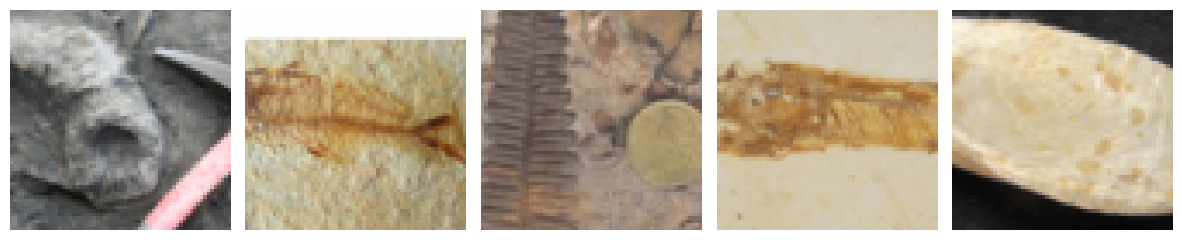

In [5]:
# Visualize some sample images
images = []
cols, rows = 5, 1
for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img = training_data[sample_idx]
    images.append(img)
display_image_grid(images, rows, cols)

# A Simple Autoencoder (Linear Autoencoder)

We'll start off by building a simple autoencoder to compress the FossilNET dataset.

Autoencoders are a type of neural network where the input is also the output. They are an unsupervised learning algorithm, meaning that they do not require labeled data. An autoencoder consists of two parts: an encoder and a decoder. They follow the same principle of dimensionality reduction as in linear algebra, but using a neural network. The idea is to take a higher-dimensional input, project it into a lower-dimensional space, and then project it back into the input space. Figure 1 shows the typical architecture of autoencoders.

The encoder receives the input and encodes it into a lower dimension. This encoding is simply called the code. The code represents the summary of the input. The decoder takes this code and reconstructs the input from it.

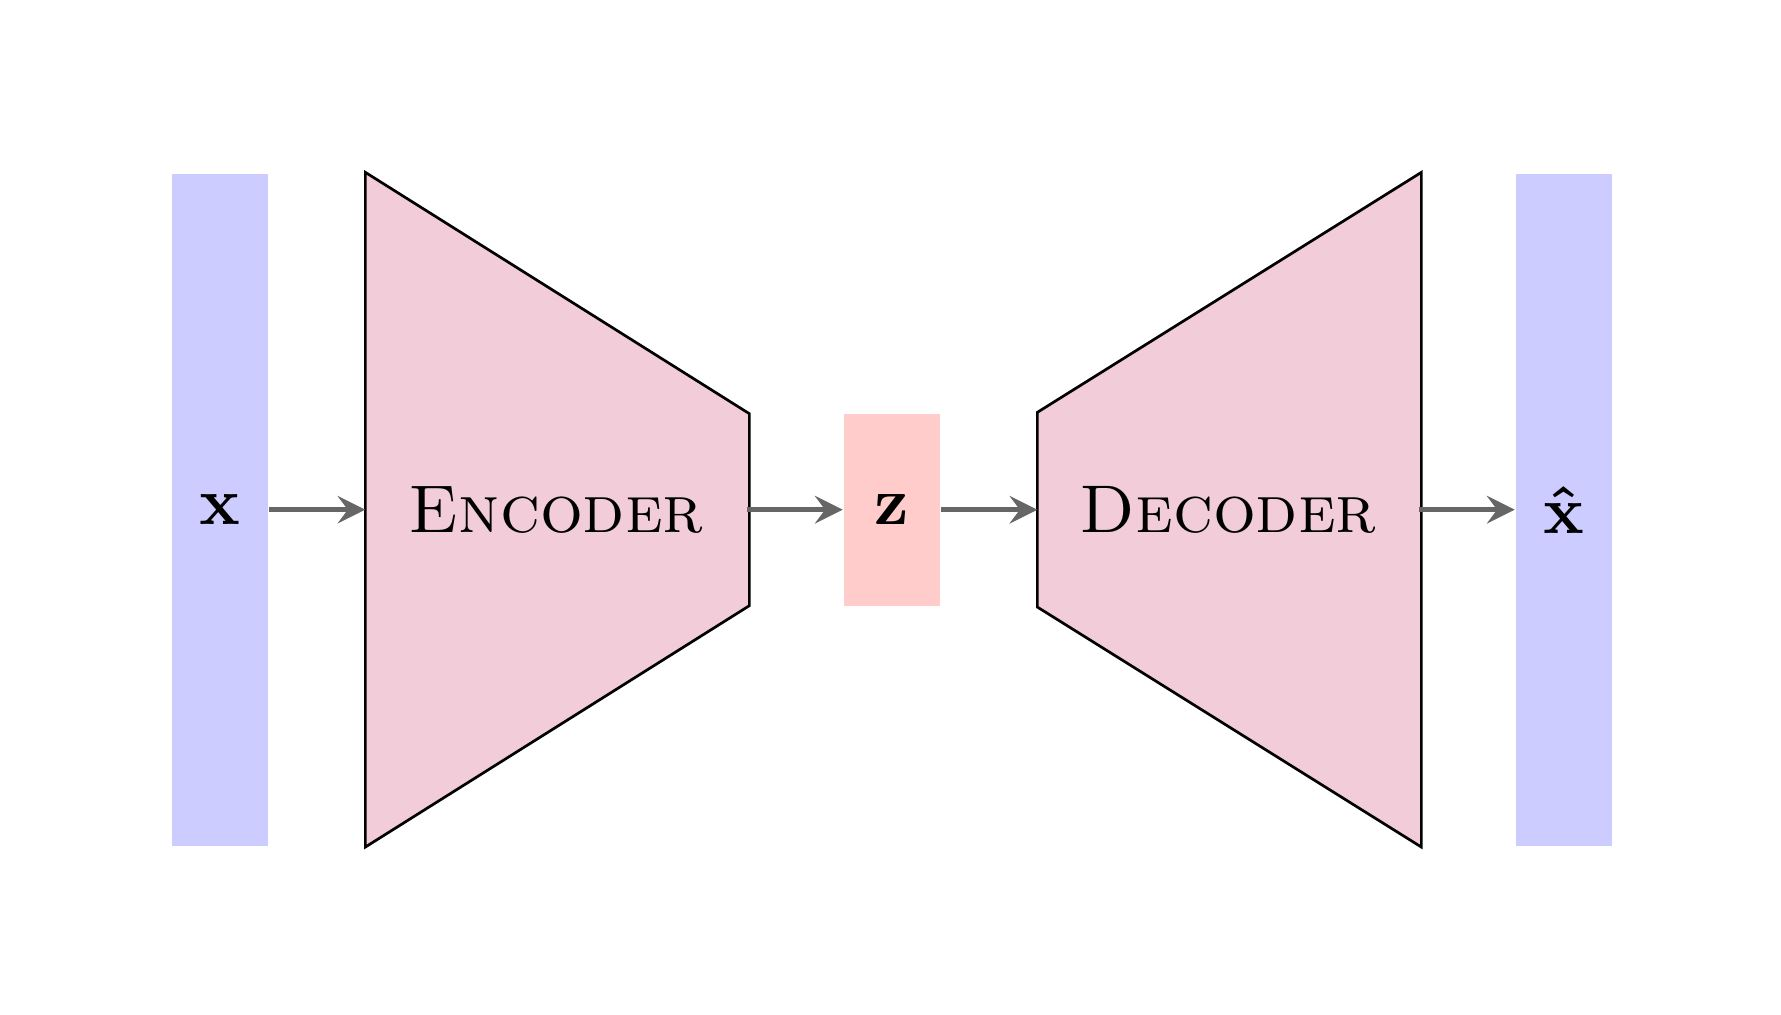
<p align = "center">
Fig.1 - Autoencoder Architecture  
(<a href="https://github.com/JamesAllingham/LaTeX-TikZ-Diagrams">
source
</a>)
</p>

We'll train an autoencoder with these images by flattening them into vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of one linear layer. The units that connect the encoder and decoder will be the compressed representation.

Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range.

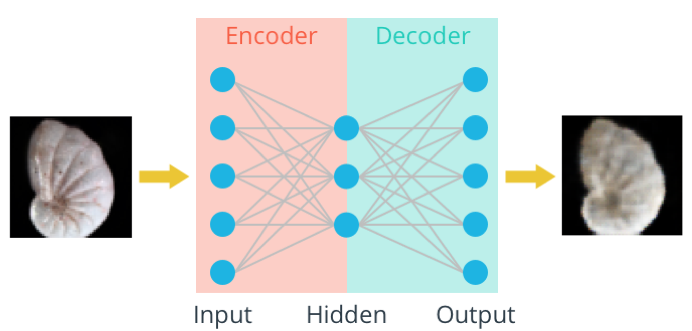

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
# Define the network architecture
class Autoencoder(nn.Module):
    
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()

        num_channels = input_dim[0]
        height = input_dim[1]
        width = input_dim[2]
        num_features = num_channels * height * width
        
        self.encoder = nn.Sequential(
            nn.Flatten(1, -1),
            nn.Linear(num_features, latent_dim),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, num_features),
            nn.Sigmoid(),
            nn.Unflatten(1, input_dim)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def test(self, x):
        print(x.shape)
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x)
        print(x.shape)
        return x


In [8]:
# Initialize the network
model = Autoencoder(input_dim=training_data[0].shape, latent_dim=32)
model = model.to(device)
print(model)
summary(model, training_data[0].shape)

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=32, bias=True)
    (2): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=12288, bias=True)
    (1): Sigmoid()
    (2): Unflatten(dim=1, unflattened_size=torch.Size([3, 64, 64]))
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 12288]               0
            Linear-2                   [-1, 32]         393,248
              ReLU-3                   [-1, 32]               0
            Linear-4                [-1, 12288]         405,504
           Sigmoid-5                [-1, 12288]               0
         Unflatten-6            [-1, 3, 64, 64]               0
Total params: 798,752
Trainable params: 798,752
Non-trainable params: 0
----------------------------------------------------------------
Input 

In [9]:
# Test the network
img = training_data[0].unsqueeze(0).to(device)
_ = model.test(img)

torch.Size([1, 3, 64, 64])
torch.Size([1, 32])
torch.Size([1, 3, 64, 64])


In [10]:
# Model hyperparameters
EPOCHS = 100
LEARNING_RATE = 5e-4
BATCH_SIZE = 64

Typically, mean squared is used as the loss function for autoencoders. The  objective is to minimize the following:
$$ L(x,\hat{x}) = \frac{1}{N} \sum^{N}_{i=1} ||x_{i}-\hat{x}_{i}||^{2} $$

In [11]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss()

In [12]:
# Initialize PyTorch data loader
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
# Training loop
loss_history = []

for i in range(1,EPOCHS+1):
    
    running_loss = 0
    pbar = tqdm(train_dataloader)
    
    for b, data in enumerate(pbar):
        
        # Get the data instances
        inputs = data
        inputs = inputs.to(device)
        
        # Zero the gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, inputs)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()

        # Update progress
        running_loss += loss.item()
        pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
        pbar.set_postfix({"loss": loss.item(), "avloss": running_loss/(b+1)})
        
    loss_history.append(running_loss)

Epoch 100/100: : 100%|█████████████████████████████████████| 32/32 [00:04<00:00,  6.62it/s, loss=0.0547, avloss=0.0559]


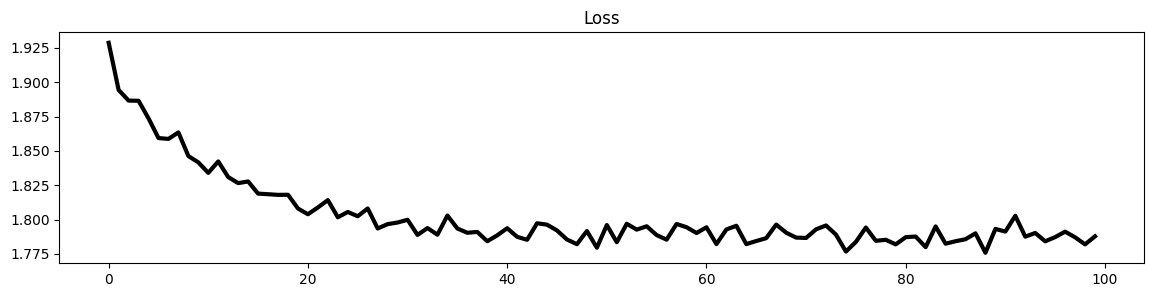

In [14]:
# Visualize the loss function
plt.figure(figsize=(14, 3))
plt.plot(loss_history, 'k', lw=3)
plt.title('Loss');

In [15]:
# Set the model to eval state
_ = model.eval()

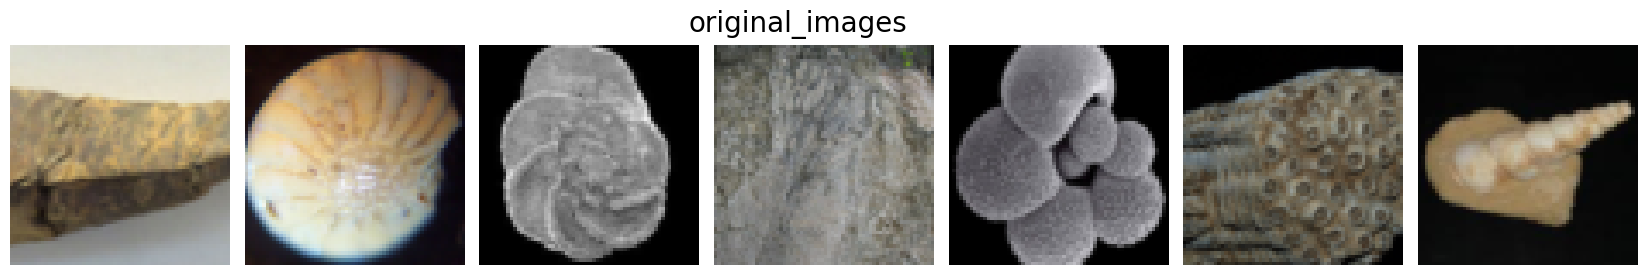

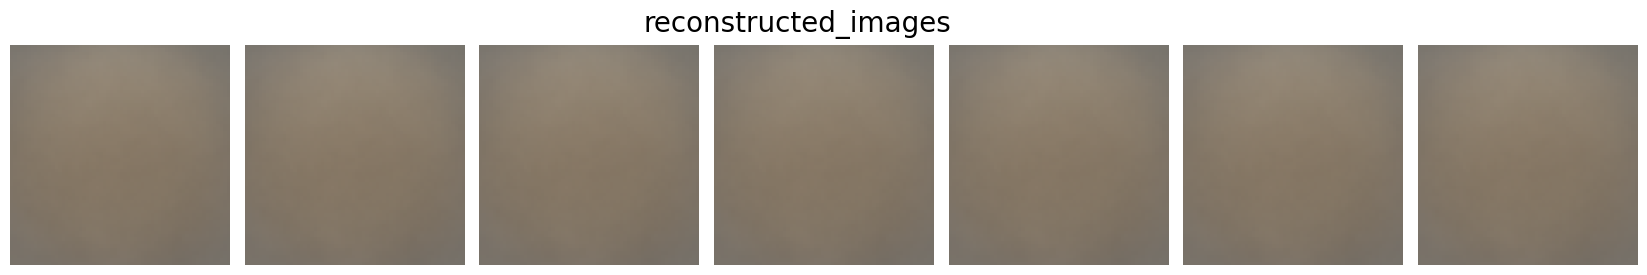

In [16]:
# Display some sample images and their reconstruction through autoencoders
images = []
cols, rows = 7, 1
for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img = training_data[sample_idx]
    images.append(img)
display_image_grid(images, rows, cols, "original_images")

with torch.no_grad():
    reconstructed_images = model(torch.stack(images).to(device)).cpu()
display_image_grid(reconstructed_images.squeeze(1), rows, cols, "reconstructed_images")

# Convolutional Autoencoders

As we're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.

We will build the autoencoder model as shown in Figure 2. It is common practice to build the encoder and decoder as inverses of each other, but this is not strictly necessary as long as the input and output spaces are the same.

The representational power of the encoder depends on the size of the encoder network and the encoding dimension. The larger the encoder network and the value of z (encoding dimension), the better the representation, but this can come at the cost of overfitting. Therefore, it is important to balance these two factors.

Typically, there is no activation function on the encoding layer. However, in this case, since our goal is to sample the encodings and generate new samples, it is better to limit the space of encodings. Therefore, we will apply a tanh activation function at the encoding layer to limit the encoding space.

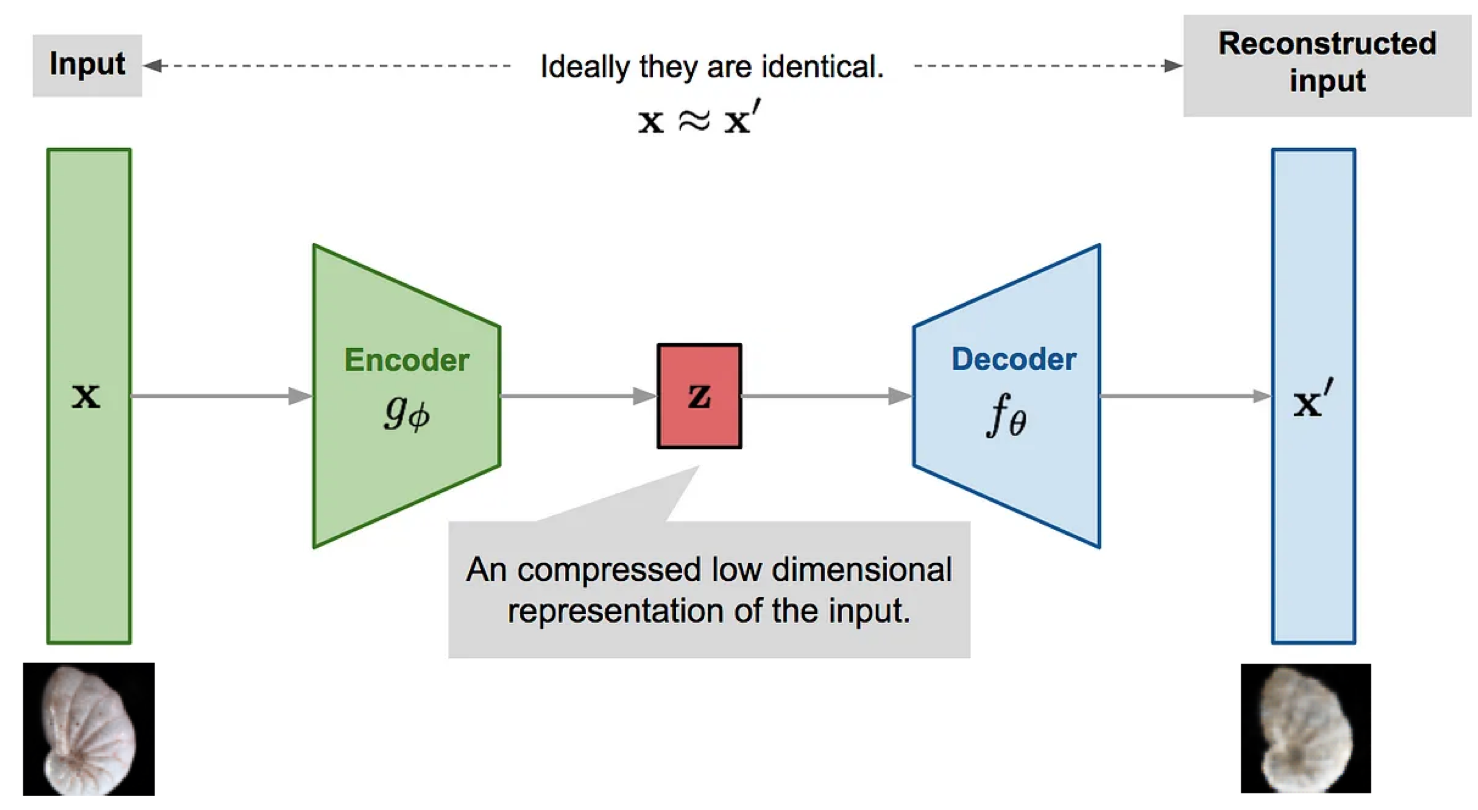
<p align = "center">
Fig.2 - Sample image of an Autoencoder  
(<a href="https://medium.com/analytics-vidhya/building-a-convolutional-autoencoder-using-keras-using-conv2dtranspose-ca403c8d144e">
source
</a>)
</p>

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [18]:
# Define the network architecture
class ConvAutoencoder(nn.Module):
   
    def __init__(self, input_dim, latent_dim):
        super(ConvAutoencoder, self).__init__()

        num_channels = input_dim[0]
        height = input_dim[1]
        width = input_dim[2]
        
        lat_h = height // 8
        lat_w = width // 8
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Flatten(1,-1),
            nn.Linear(128 * lat_h * lat_w, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, latent_dim),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, 128 * lat_h * lat_w),
            nn.BatchNorm1d(128 * lat_h * lat_w),
            nn.LeakyReLU(),

            nn.Unflatten(1, (128, lat_h, lat_w)),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=num_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def test(self, x):
        print(x.shape)
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x)
        print(x.shape)
        return x


In [19]:
# Initialize the network
z = 256
model = ConvAutoencoder(input_dim=training_data[0].shape, latent_dim=z)
model.to(device)
print(model)
summary(model, training_data[0].shape)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8192, out_features=512, bias=True)
    (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): Tanh()
  )
  (decoder): Sequential

In [20]:
# Test the network
img = training_data[0].unsqueeze(0).repeat((2, 1, 1, 1)).to(device)
_ = model.test(img)

torch.Size([2, 3, 64, 64])
torch.Size([2, 256])
torch.Size([2, 3, 64, 64])


In [21]:
# Model hyperparameters
EPOCHS = 100
LEARNING_RATE = 5e-4
BATCH_SIZE = 64

In [22]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss()

In [23]:
# Initialize PyTorch data loader
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

In [24]:
# Training loop
loss_history = []

for i in range(1,EPOCHS+1):
    
    running_loss = 0
    pbar = tqdm(train_dataloader)
    
    for b, data in enumerate(pbar):
        
        # Get the data instances
        inputs = data
        inputs = inputs.to(device)

        # Zero the gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, inputs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Update Progress
        running_loss += loss.item()
        pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
        pbar.set_postfix({"loss": loss.item(), "avloss": running_loss/(b+1)})
        
    loss_history.append(running_loss)

Epoch 100/100: : 100%|███████████████████████████████████| 32/32 [00:07<00:00,  4.20it/s, loss=0.00695, avloss=0.00483]


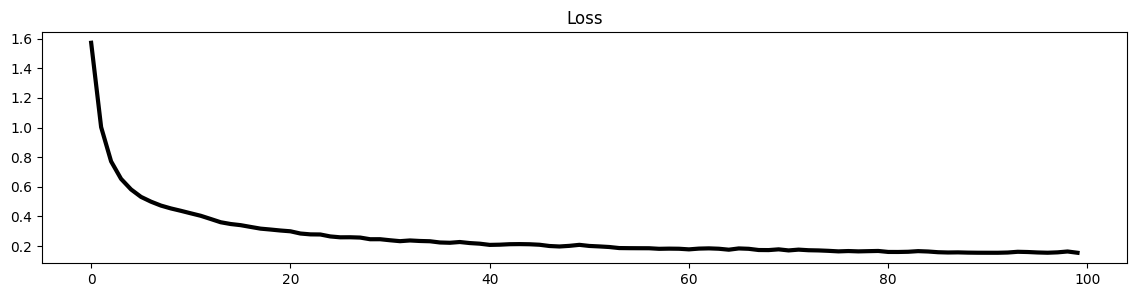

In [25]:
# Visualize the loss function
plt.figure(figsize=(14, 3))
plt.plot(loss_history, 'k', lw=3)
plt.title('Loss');

In [26]:
# Set the model to eval state
_ = model.eval()

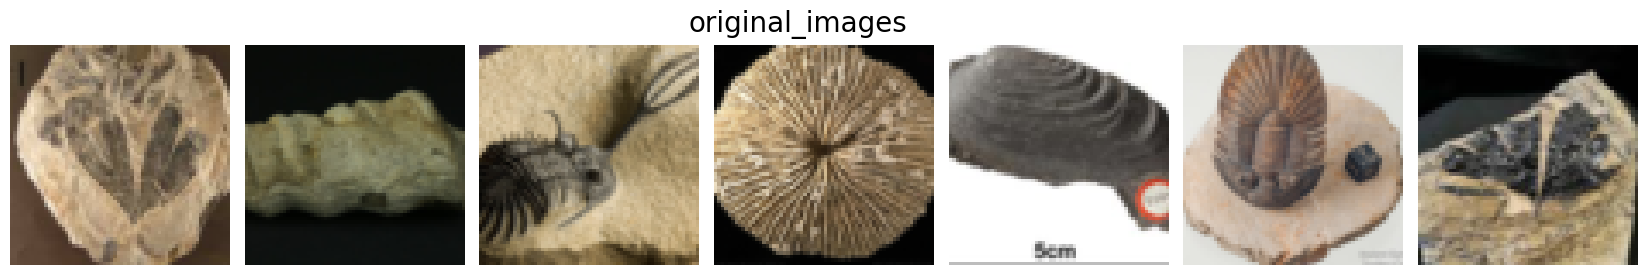

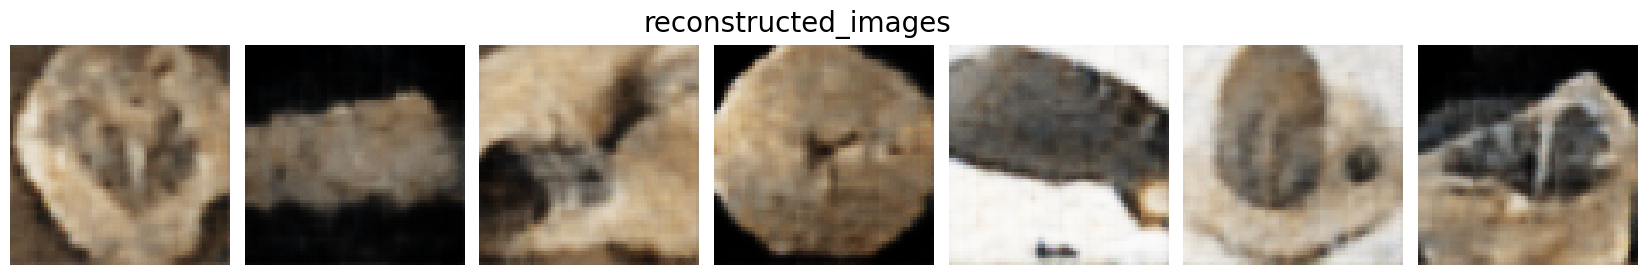

In [27]:
# Display some sample images and there reconstruction through autoencoders
images = []
cols, rows = 7, 1
for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img = training_data[sample_idx]
    images.append(img)
display_image_grid(images, rows, cols, "original_images")

with torch.no_grad():
    reconstructed_images = model(torch.stack(images).to(device)).cpu()
display_image_grid(reconstructed_images.squeeze(1), rows, cols, "reconstructed_images")

## Generation through Autoencoders

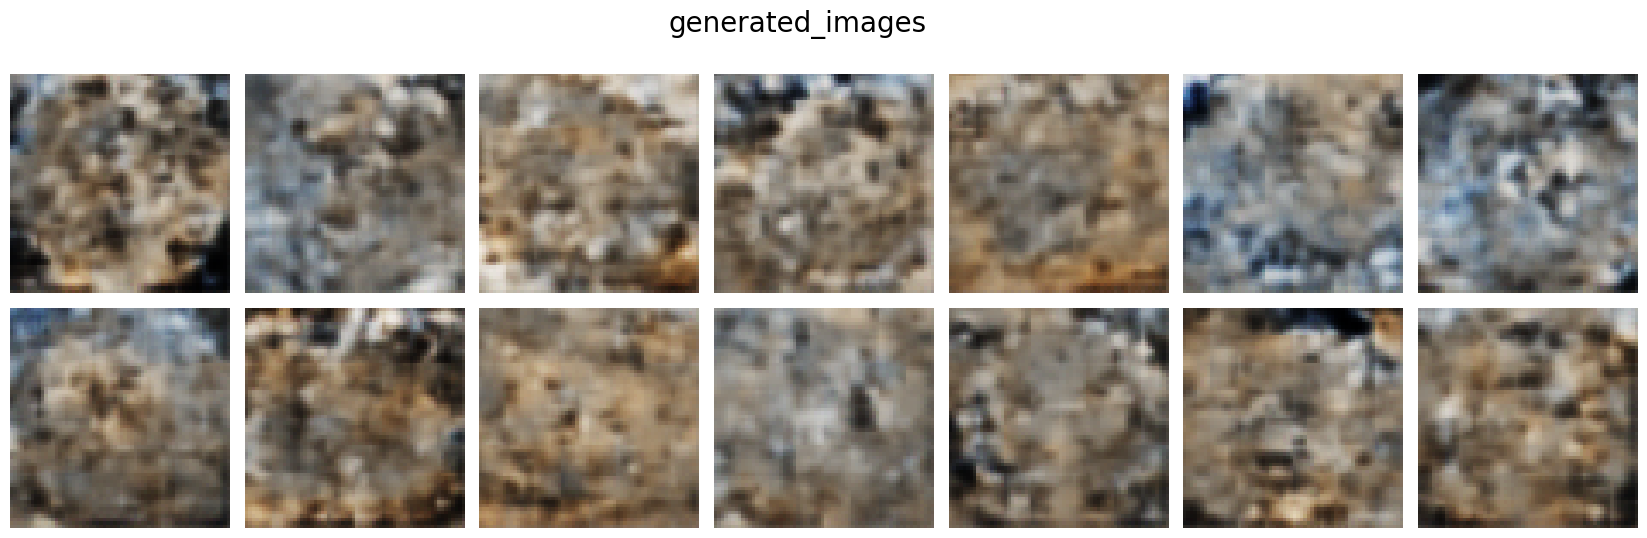

In [28]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder
rows, cols = 2, 7
sample_encodings = (torch.rand(rows*cols, z).to(device) - 0.5) * 2 # encoding space: [-1,1)
with torch.no_grad():
    generations = model.decoder(sample_encodings).cpu()
display_image_grid(generations.squeeze(1), rows, cols, "generated_images")

As we can see, we achieved near perfect image reconstruction for the data. One of the reason is obviously because the input data itself of low dimenstion but the other is that autoencoders are fairly good at encoding the data.

But in the case of generation, we did not get good results. This goes to show us that auto encoders have very low generative abilities because they tend to overfit and just learn the function that maps the input to output.